<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter==2.0.4+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==0.6.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==1.5.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==1.2.0+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 15.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 225kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 1.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 1.4MB/s 
     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 235kB 2.7MB/s 
     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.0-cp36-none-any.whl size=296339 sha256=e310deb39292d254ca308d99c43159012ee02d16f051682bd734ec6d78dabd15
  Stored in directory: /root/.cache/pip/wh

In [12]:
import copy
import itertools
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_geometric as geo
import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook I'd like to start doing some sensitivity analysis of the model, i.e. seeing if it reacts in the way one would expect to changes in bilateral relationships.

In [3]:
class RecurGraphNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_output_features):
        super().__init__()

        conv_layer_size = 32
        lstm_layer_size = 32

        # graph convolutional layer to create graph representation
        conv_lin = torch.nn.Linear(num_edge_features, num_node_features * conv_layer_size)
        self.conv = geo.nn.NNConv(num_node_features, conv_layer_size, conv_lin)

        # lstm to learn sequential patterns
        self.lstm = torch.nn.LSTM(conv_layer_size, lstm_layer_size, dropout=0.5)

        # initial trainable hidden state for lstm
        self.lstm_h_s = torch.nn.Linear(num_output_features, lstm_layer_size)
        self.lstm_c_s = torch.nn.Linear(num_output_features, lstm_layer_size)

        # final linear layer to allow full expressivity for regression after tanh activation in lstm
        self.final_linear = torch.nn.Linear(lstm_layer_size, num_output_features)

    def forward(self, input):
        initial, sequence = input.initial, input.sequence
        
        # create graph representation
        graph_collection = []
        for idx in range(len(sequence)):
            x, edge_index, edge_attr = sequence[idx].x, sequence[idx].edge_index, sequence[idx].edge_attr
            graph_step = torch.nn.functional.relu(self.conv(x, edge_index, edge_attr))
            graph_collection.append(graph_step)
        # provide graph representations as sequence to lstm
        graph_series = torch.stack(graph_collection)

        # recurrent stage
        # initial state of lstm is representation of target prior to this sequence
        lstm_output, _ = self.lstm(graph_series, (self.lstm_h_s(initial).unsqueeze(0), self.lstm_c_s(initial).unsqueeze(0)))

        # final activation is relu as this is for regression and the metrics of this dataset are all positive
        return self.final_linear(lstm_output)

In [4]:
class Sequence():
    def __init__(self, initial=None, sequence=None, missing_mask=torch.empty(0), target=torch.empty(0)):
        self.initial = initial
        self.sequence = sequence
        self.missing_mask = missing_mask
        self.target = target

    def to(self, device):
        self.initial = self.initial.to(device)
        self.missing_mask = self.missing_mask.to(device)
        self.target = self.target.to(device)
        for idx in range(len(self.sequence)):
            self.sequence[idx] = self.sequence[idx].to(device)
        return self

In [5]:
@torch.no_grad()
def get_prediction(recur_seq):
    # get prediction of recurrent model
    recur_seq = recur_seq.to(device)
    recur_prediction = recur_model(recur_seq)

    return recur_prediction

In [6]:
def plot_prediction(sequence):
    pred = get_prediction(sequence)

    plt.plot(pred[:, 0, 0], label="Anarres")
    plt.plot(pred[:, 1, 0], label="A-Io")
    plt.plot(pred[:, 2, 0], label="Thu")

    plt.legend()
    plt.show()

Create a model

In [7]:
root = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = 2
num_edge_features = 7
num_targets = 1

recur_model = RecurGraphNet(num_node_features, num_edge_features, num_targets)
recur_model = recur_model.to(device)
recur_model.load_state_dict(torch.load(os.path.join(root, 'best_model_recurrent.pkl')))

<All keys matched successfully>

Lets create a simple scenario with three countries, with distinct democratization differences, and see how changes in their relationships affects their democratic tendencies over time. Lets call them A-Io, Thu and Anarres. For the first test we will keep everything constant over time, with no edges defined.

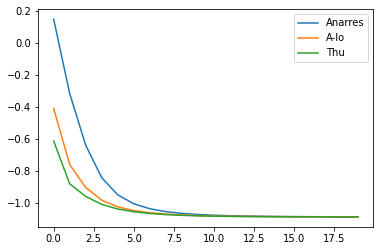

In [8]:
years = 20

# Anarres
anarres_initial = 0.95
# A-Io
aio_initial = 0.55
# Thu
thu_initial = 0.25

countries_initial = torch.tensor([anarres_initial, aio_initial, thu_initial], dtype=torch.float32).view(-1, 1)

# all nations will have the same constant gdp and pop
all_years = []
for year in range(years):
    x = [[0,0], [0,0], [0,0]]
    all_years.append(geo.data.Data(x=torch.tensor(x, dtype=torch.float32),
                                   edge_index = torch.empty(2, 0, dtype=torch.long),
                                   edge_attr = torch.empty(0, num_edge_features, dtype=torch.float32)))

sequence = Sequence(initial=countries_initial, sequence=all_years)

plot_prediction(sequence)

Here the model predicts that stagnation in GDP and population with no trade leads to totalitarianism. Next we'll try an increasing GDP and population.

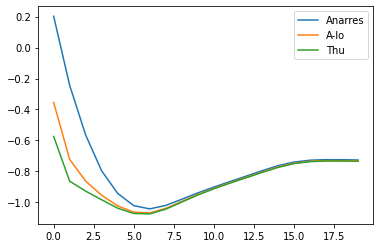

In [13]:
# all nations will have the same constant gdp and pop
all_years = []
initial_pop_gdp = torch.Tensor([[-0.9,-0.9], [-0.9,-0.9], [-0.9,-0.9]])
add_pop_gdp = torch.Tensor([[0.3,0.3], [0.3,0.3], [0.3,0.3]])
for year in range(years):
    x = initial_pop_gdp + year * add_pop_gdp
    all_years.append(geo.data.Data(x=torch.tensor(x, dtype=torch.float32),
                                   edge_index = torch.empty(2, 0, dtype=torch.long),
                                   edge_attr = torch.empty(0, num_edge_features, dtype=torch.float32)))

sequence = Sequence(initial=countries_initial, sequence=copy.deepcopy(all_years))

plot_prediction(sequence)

Increasing GDP and population does lead to democratization, but this effect seems to plateau after a certain increase. We'll now see what happens when Thu, the least democratic nation, has increasing imports from Anarres, the most democratic nation.

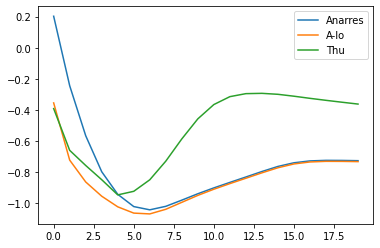

In [15]:
# all nations will have the same constant gdp and pop
initial_edge = torch.tensor([0, -0.5, -0.5, -0.5, 0, -0.5, -1], dtype=torch.float32)
add_edge = torch.tensor([0, 0, 0, 0, 0, 0, 0.3], dtype=torch.float32)
edge_index = torch.tensor([[0], [2]], dtype=torch.long)
for idx, year in enumerate(all_years):
    year.edge_index = edge_index
    year.edge_attr = initial_edge + idx * add_edge

sequence = Sequence(initial=countries_initial, sequence=all_years)

plot_prediction(sequence)